# Step 2. Training (Transfer Learning) and Validation
Here I have used a **ResNet152**  implementation from fastai and the results are pretty good. 

In [1]:
!pip install fastai

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai.metrics import error_rate
from fastai import *
import cv2 as cv
import numpy as np
import pandas as pd
import scipy.io as sio

In [0]:
path='/content'

In [0]:
#from google.colab import drive
#drive.mount(path+'/gdrive')

# Using pretrained model
I have augmented Image data for better results. I have set different rotaion angles, mirroring and different zoom options so that robust model can be created. Training and validation data is passed into the ResNet152 model. At first, I have tried to use pretrained model (training only for fully connected layers at last) with only 4 epochs and validation set accuracy is 70% which is very good and can be improved by training after unfreezing all layers and using higher epochs with tuned learning rate.

In [4]:
data = ImageDataBunch.from_folder(path+'/','train','valid',
                                  ds_tfms=get_transforms(do_flip=False, flip_vert=True, max_rotate=5.0,max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75),
                                  size=224,bs=32).normalize(imagenet_stats)
learn = cnn_learner(data, models.resnet152, metrics=accuracy)
learn.fit_one_cycle(4)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:04<00:00, 54778889.25it/s]


epoch,train_loss,valid_loss,accuracy,time
0,4.140042,3.184346,0.274401,02:07
1,2.319937,1.732128,0.545734,02:11
2,1.355891,1.170118,0.689380,02:12
3,0.843437,1.076269,0.701657,02:12


# Training model after unfreezing
I have found out optimal learning rate and used that to train the model. It has taken a while to train the model but the accuracy has been 88%. 

In [8]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [9]:
learn.unfreeze()
learn.fit_one_cycle(15, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.759768,1.066893,0.710252,02:47
1,0.699446,0.962077,0.740945,02:46
2,0.592060,0.872909,0.773481,02:46
3,0.460677,0.760785,0.799877,02:46
4,0.339923,0.685304,0.813996,02:46
5,0.266377,0.664071,0.817066,02:46
6,0.195507,0.592454,0.832413,02:46
7,0.143953,0.554602,0.854512,02:46
8,0.099264,0.540946,0.847759,02:46
9,0.077664,0.502908,0.861878,02:46


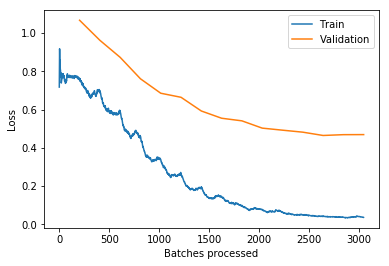

In [10]:
learn.recorder.plot_losses()

In [0]:
learn.save('resnet152')

In [0]:
learn.export(path+'/models/export.pkl')

# Accuracy on test dataset

In [5]:
!wget http://imagenet.stanford.edu/internal/car196/cars_test_annos_withlabels.mat -P devkit
labels = sio.loadmat(path+'/devkit/cars_test_annos_withlabels.mat')

--2019-06-16 08:20:24--  http://imagenet.stanford.edu/internal/car196/cars_test_annos_withlabels.mat
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 185758 (181K) [text/plain]
Saving to: ‘devkit/cars_test_annos_withlabels.mat’

cars_test_annos_wit 100%[===================>] 181.40K   313KB/s    in 0.6s    

2019-06-16 08:20:25 (313 KB/s) - ‘devkit/cars_test_annos_withlabels.mat’ saved [185758/185758]



In [62]:
x = []
for i in range(8041):
  x.append(np.transpose(np.array(labels['annotations']['fname']))[i][0][0])

df=pd.DataFrame(data=np.transpose(np.array(labels['annotations']['class'],dtype=np.int)),index=x)
df.to_csv(path+'/test_labels.csv')
learn = load_learner(path+'/models/', test= ImageList.from_csv(path+'/','test_labels.csv',folder='test'))
preds,y = learn.TTA(ds_type=DatasetType.Test)
b=np.array(labels['annotations']['class'],dtype=np.int)-1;b.shape #lbels in range [0..195]
b = torch.from_numpy(b)
acc=accuracy(preds,b)
print(acc)

tensor(0.8802)


**Accuracy on test dataset of 8041 cars is around 88%.**